In [1]:
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import interpolate 
sys.path.append(r'C:\Chuji\Code_and_Data\MyCode')

import Circuit_Simulator 
import PulseGenerator as PG
from toolfunc import *
from toolfunc.adia_analysis import *
from toolfunc.pulse_filter import *
import scipy.optimize as sci_op
from toolfunc import DE

{'Q1_freq': '6000.0MHz', 'Q1_anhar': '-125.0MHz', 'Q2_freq': '8000.0MHz', 'Q2_anhar': '-150.0MHz', 'Q3_freq': '5400.0MHz', 'Q3_anhar': '-125.0MHz', 'g12': '83.1384MHz', 'g13': '4.5537MHz', 'g23': '78.872MHz'}


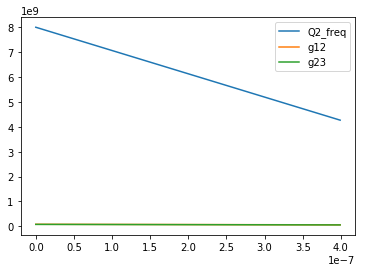

In [2]:
raw_config = Circuit_Simulator.RawConfig(qubit_num=3,dimension=3,circuit_type=1,initial_state='ground',sampling_rate=1e9)
raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)

flux_pulse = np.linspace(0/7.5,4/7.5,400)
freq_array = 8.5e9-flux_pulse * (8.5e9 - 1e9)

raw_config.setValue('Q1 f01_max',6.0e9)
raw_config.setValue('Q2 f01_max',8.0e9)
raw_config.setValue('Q3 f01_max',5.4e9)
raw_config.setValue('Q1 f01_min',1e9)
raw_config.setValue('Q2 f01_min',1e9)
raw_config.setValue('Q3 f01_min',1e9)
raw_config.setValue('Q1 Ec',0.25e9)
raw_config.setValue('Q2 Ec',0.30e9)
raw_config.setValue('Q3 Ec',0.25e9)

raw_config.setValue('r12',0.012)
raw_config.setValue('r23',0.012)
raw_config.setValue('r13',0.0008)

raw_config.setValue('Q2 Voltage period',-1)
raw_config.setValue('Q2 Voltage operating point',0.00)
raw_config.setValue('Q2 Flux',flux_pulse)

simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
Simulator = Circuit_Simulator.Simulator(simu_config)
Simulator.show_pulse()

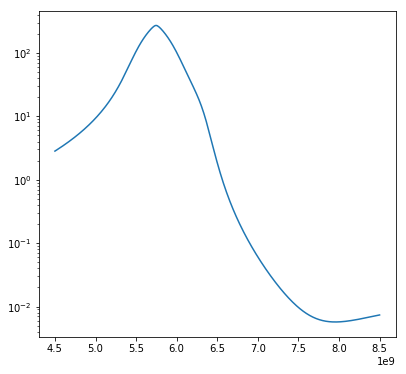

In [3]:
Simulator.performsimulation(solver_type=2,resample_factor=1,eigen_cloest_to_bare=False ,sort_by_maximum_overlap=True,gap=12e6)

fig = plt.figure(figsize=[6.4,6])
ax = fig.add_subplot(111)

eigen_trace = Simulator.EigenResult.get_Ener_gap_trace('101-100-001+000')
ax.plot(freq_array[0:400],-eigen_trace[0:400]/1e6)

ax.set_yscale('log')

In [4]:
%matplotlib inline

In [5]:
def cost_func_distor_18(pulse_params,*args):
    gate_time,SRATE,f_term,factor_r,T_reflec=args
    lamb1 = pulse_params
    total_len = gate_time + 8e-9+4*T_reflec
    
    Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
    Seq.clear_pulse(tips_on=False)
    Seq.add_pulse('Adiabatic',t0=gate_time/2+10e-9/2,width=gate_time,plateau=0e-9,frequency=0,F_Terms=f_term,Lcoeff=np.array(lamb1),Q1_freq=6.0e9,
                 CPLR_idle_freq=7.87e9,Q2_freq=5.4e9,constant_coupling=False,r1c=0.018,r2c=0.018,r12=0.0015,anhar_CPLR=-300e6,
                 anhar_Q1=-250e6,anhar_Q2=-250e6,negative_amplitude=False,dfdV=7.87e9-1e9,gap_threshold=8e6,freqpoints=301,pulsepoints=601)
    Seq.add_filter('Gauss Low Pass',300e6)
    Seq.add_filter('Reflection',*(factor_r,T_reflec))
    flux_pulse=Seq.get_sequence()

    raw_config = Circuit_Simulator.RawConfig(qubit_num=3,dimension=3,circuit_type=1,initial_state='-Z+Z+Z',sampling_rate=SRATE)
    raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)
    
    raw_config.setValue('Q1 f01_max',6.0e9)
    raw_config.setValue('Q2 f01_max',7.87e9)
    raw_config.setValue('Q3 f01_max',5.4e9)
    raw_config.setValue('Q1 f01_min',1e9)
    raw_config.setValue('Q2 f01_min',1e9)
    raw_config.setValue('Q3 f01_min',1e9)
    raw_config.setValue('Q1 Ec',0.25e9)
    raw_config.setValue('Q2 Ec',0.3e9)
    raw_config.setValue('Q3 Ec',0.25e9)
    raw_config.setValue('r12',0.018)
    raw_config.setValue('r23',0.018)
    raw_config.setValue('r13',0.0015)
    raw_config.setValue('Q2 Voltage period',-1)
    raw_config.setValue('Q2 Voltage operating point',0)
    raw_config.setValue('Q2 Flux',flux_pulse)

    simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
    Simulator = Circuit_Simulator.Simulator(simu_config)

    Simulator.performsimulation(solver_type=1)
    Simulator.UnitaryResult.get_U(-1)
    Simulator.UnitaryResult.get_subspace_operator(['000','001','100','101'])
    Simulator.UnitaryResult.set_Target_gate('CZ')
    Simulator.UnitaryResult.remove_single_qubit_gate()
    Simulator.UnitaryResult.get_Gate_Fidelity()
    fidelity = Simulator.UnitaryResult.Gate_Fidelity
    return 1 - fidelity

In [6]:
SRATE=6e9
gate_time=20e-9
f_terms=1
T_r=5e-9

factor_r_arr =  np.linspace(-0.1,0.1,41)
gate_fidelity_one = np.zeros([len(factor_r_arr)])
gate_params_one = np.zeros([len(factor_r_arr)])
raw_initial_seeds=np.array([0.8])


jj = 0
for factor_r in factor_r_arr:
    time_start = time.time()
    DATA = sci_op.minimize(cost_func_distor_18,raw_initial_seeds,args=(gate_time,SRATE,f_terms,factor_r,T_r), method='Nelder-Mead', options={'disp': True,'ftol':1e-4,'xtol':1e-4,'maxiter':30})

    gate_fidelity_one[jj] = DATA.fun
    gate_params_one[jj] = DATA.x

    print('fidelity',DATA.fun)
    print(time.time()-time_start)
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_versus_gate_time\param_20ns.txt',gate_params_one )
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_versus_gate_time\error_20ns.txt',gate_fidelity_one )
    jj+=1

Optimization terminated successfully.
         Current function value: 0.008922
         Iterations: 12
         Function evaluations: 24
fidelity 0.008921661724680119
38.47461915016174
Optimization terminated successfully.
         Current function value: 0.008127
         Iterations: 13
         Function evaluations: 26
fidelity 0.008127393246326386
42.928972244262695
Optimization terminated successfully.
         Current function value: 0.007408
         Iterations: 13
         Function evaluations: 26
fidelity 0.0074081818352254025
41.48077440261841
Optimization terminated successfully.
         Current function value: 0.006757
         Iterations: 13
         Function evaluations: 26
fidelity 0.006756787149972299
41.79513955116272
Optimization terminated successfully.
         Current function value: 0.006165
         Iterations: 14
         Function evaluations: 28
fidelity 0.0061649514327047905
43.901355028152466
Optimization terminated successfully.
         Current function va

In [7]:
SRATE=6e9
gate_time=40e-9
f_terms=1
T_r=5e-9

factor_r_arr =  np.linspace(-0.1,0.1,41)
gate_fidelity_one = np.zeros([len(factor_r_arr)])
gate_params_one = np.zeros([len(factor_r_arr)])
raw_initial_seeds=np.array([0.8])


jj = 0
for factor_r in factor_r_arr:
    time_start = time.time()
    DATA = sci_op.minimize(cost_func_distor_18,raw_initial_seeds,args=(gate_time,SRATE,f_terms,factor_r,T_r), method='Nelder-Mead', options={'disp': True,'ftol':1e-4,'xtol':1e-4,'maxiter':30})

    gate_fidelity_one[jj] = DATA.fun
    gate_params_one[jj] = DATA.x

    print('fidelity',DATA.fun)
    print(time.time()-time_start)
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_versus_gate_time\param_40ns.txt',gate_params_one )
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_versus_gate_time\error_40ns.txt',gate_fidelity_one )
    jj+=1
    

################################################################
################################################################
#####################################################################################
    
    
    
SRATE=6e9
gate_time=50e-9
f_terms=1
T_r=5e-9
factor_r_arr =  np.linspace(-0.1,0.1,41)
gate_fidelity_one = np.zeros([len(factor_r_arr)])
gate_params_one = np.zeros([len(factor_r_arr)])
raw_initial_seeds=np.array([0.8])


jj = 0
for factor_r in factor_r_arr:
    time_start = time.time()
    DATA = sci_op.minimize(cost_func_distor_18,raw_initial_seeds,args=(gate_time,SRATE,f_terms,factor_r,T_r), method='Nelder-Mead', options={'disp': True,'ftol':1e-4,'xtol':1e-4,'maxiter':30})

    gate_fidelity_one[jj] = DATA.fun
    gate_params_one[jj] = DATA.x

    print('fidelity',DATA.fun)
    print(time.time()-time_start)
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_versus_gate_time\param_40ns.txt',gate_params_one )
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_versus_gate_time\error_40ns.txt',gate_fidelity_one )
    jj+=1

Optimization terminated successfully.
         Current function value: 0.008501
         Iterations: 10
         Function evaluations: 20
fidelity 0.00850056655855247
40.4994158744812
Optimization terminated successfully.
         Current function value: 0.007472
         Iterations: 10
         Function evaluations: 20
fidelity 0.007471971828623136
39.286943435668945
Optimization terminated successfully.
         Current function value: 0.006469
         Iterations: 10
         Function evaluations: 20
fidelity 0.006469407778730174
39.54173445701599
Optimization terminated successfully.
         Current function value: 0.005523
         Iterations: 10
         Function evaluations: 20
fidelity 0.005522687492315326
39.47718167304993
Optimization terminated successfully.
         Current function value: 0.004656
         Iterations: 10
         Function evaluations: 20
fidelity 0.0046555827384284765
38.90840792655945
Optimization terminated successfully.
         Current function value:

Optimization terminated successfully.
         Current function value: 0.003128
         Iterations: 10
         Function evaluations: 20
fidelity 0.003127831934842451
40.599623918533325
Optimization terminated successfully.
         Current function value: 0.002606
         Iterations: 10
         Function evaluations: 20
fidelity 0.002605677984035326
40.702789545059204
Optimization terminated successfully.
         Current function value: 0.002199
         Iterations: 10
         Function evaluations: 20
fidelity 0.002199233664837652
40.56800127029419
Optimization terminated successfully.
         Current function value: 0.001890
         Iterations: 10
         Function evaluations: 20
fidelity 0.0018898885496712037
40.61493229866028
Optimization terminated successfully.
         Current function value: 0.001658
         Iterations: 10
         Function evaluations: 20
fidelity 0.0016576276210411578
40.70246648788452
Optimization terminated successfully.
         Current function va

In [8]:
SRATE=6e9
gate_time=60e-9
f_terms=1
T_r=5e-9
factor_r_arr =  np.linspace(-0.1,0.1,41)
gate_fidelity_one = np.zeros([len(factor_r_arr)])
gate_params_one = np.zeros([len(factor_r_arr)])
raw_initial_seeds=np.array([0.8])


jj = 0
for factor_r in factor_r_arr:
    time_start = time.time()
    DATA = sci_op.minimize(cost_func_distor_18,raw_initial_seeds,args=(gate_time,SRATE,f_terms,factor_r,T_r), method='Nelder-Mead', options={'disp': True,'ftol':1e-4,'xtol':1e-4,'maxiter':30})

    gate_fidelity_one[jj] = DATA.fun
    gate_params_one[jj] = DATA.x

    print('fidelity',DATA.fun)
    print(time.time()-time_start)
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_versus_gate_time\param_60ns.txt',gate_params_one )
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_versus_gate_time\error_60ns.txt',gate_fidelity_one )
    jj+=1

Optimization terminated successfully.
         Current function value: 0.016777
         Iterations: 11
         Function evaluations: 22
fidelity 0.016776858090312263
52.12373065948486
Optimization terminated successfully.
         Current function value: 0.002617
         Iterations: 13
         Function evaluations: 28
fidelity 0.0026166627100354667
63.104905128479004
Optimization terminated successfully.
         Current function value: 0.003349
         Iterations: 10
         Function evaluations: 20
fidelity 0.003349071904901968
44.81692862510681
Optimization terminated successfully.
         Current function value: 0.003004
         Iterations: 10
         Function evaluations: 20
fidelity 0.0030043522924932953
48.348055362701416
Optimization terminated successfully.
         Current function value: 0.002743
         Iterations: 10
         Function evaluations: 20
fidelity 0.0027427479029185076
46.78459286689758
Optimization terminated successfully.
         Current function v

In [64]:
import matplotlib.ticker as mtick
fig = plt.figure(figsize=[7.6,4.8])
ax = fig.add_axes([0.2,0.10,0.75,0.8])
# ax_inset = fig.add_axes([0.35,0.36,0.4,0.5])

ax.plot(np.linspace(-0.1,0.1,41),Error_one_5ns*1,label='n=1',linewidth=3)
ax.plot(np.linspace(-0.1,0.1,21),Error_30_5ns*1,label='n=1',linewidth=3)
# ax.plot(np.linspace(-0.1,0.1,21),Error_09_5ns*1,label='n=1',linewidth=3)
ax.plot(np.linspace(-0.1,0.1,21),Error_60ns_09_5ns*1,label='n=1',linewidth=3)

# ax.plot(np.linspace(-0.1,0.1,41),Error_two_5ns*1,label='n=2',linewidth=3)

ax.set_xlim([-0.105,0.105])
# ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

ax.tick_params(axis='x',which='both',bottom=True,top=True,direction='in' )
ax.tick_params(axis='y',which='both',left=True,right=True,direction='in' )

ax.tick_params(labelsize=16)
plt.tick_params(labelsize=16)
ax.set_yscale('log')

In [48]:
%matplotlib qt